# Preprocessing Pipeline

#### To create the dataframes and files needed for our analysis, make sure that:

Make sure you have the following files in `data/raw`:
  1. [full_database.xml](https://drive.google.com/file/d/1149kYVkazq67e0vuv-_4APyqVX6yyh2p), which will represent the XML version of the DrugBank
  2. [BindingDB_All.tsv](https://www.bindingdb.org/bind/downloads/BindingDB_All_202411_tsv.zip), which will represent the tsv version of the BindingDB

Make sure you have the following directory created: `data/clean`:

### Imports

In [55]:
import os
import gc
import re
import requests
import time
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

from src.drugbank_XML_drugparser import DrugParser
from src.drugbank_bindingdb_merger import DrugBank_BindingDB_Merger
from src.preprocessing import Preprocessing, ColumnClean

from src.data_paths import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parsing and cleaning BindingDB

In [56]:
if os.path.exists(BINDINGDB_CLEAN):
    print("BindingDB clean exists...")
    clean_binding_df = pd.read_pickle(BINDINGDB_CLEAN)
else:
    print("Creating clean BindingDB...")
    def load_BindingDB(file_path, cols):
        return pd.read_csv(file_path, sep='\t', header=0, usecols=cols)

    """
    This method srips all non-numeric characters from the value.

    For example, the temperature is always given as 12C or 14.2C, so we remove the C.

    In come cases, mesured values are given as >10000 or <.01. In these cases, we just take the bound, as it is still better then loosing all the information by replacing it with NA.
    """
    def keep_just_numeric(value):
        if type(value) != str:
            if type(value) == float or type(value) == int:
                return value
            else:
                return pd.NA

        ## All non-numeric characters (except the decimal .) should be replaced
        cleaned_val = re.sub(r'[^\d.]+','', str(value)) 
        if(cleaned_val == ''): # It didn't contain any number?
            return pd.NA
        return float(cleaned_val)

    def parse_int(value):
        try:
            return int(value)
        except:
            return pd.NA
    # First, we specify which 
    bdb_preprocessor = Preprocessing(
        [
            ColumnClean('Ki (nM)', 'ki', clean=keep_just_numeric),
            ColumnClean('pH', 'ph', clean=keep_just_numeric),
            ColumnClean('Temp (C)', 'temp', clean=keep_just_numeric),
            ColumnClean('IC50 (nM)', 'ic50', clean=keep_just_numeric),
            ColumnClean('EC50 (nM)', 'ec50', clean=keep_just_numeric),
            ColumnClean('Kd (nM)', 'kd', clean=keep_just_numeric),
            ColumnClean('kon (M-1-s-1)', 'kon', clean=keep_just_numeric),
            ColumnClean('koff (s-1)', 'koff', clean=keep_just_numeric),

            # These columns are supposed to contain strings.
            ColumnClean('Article DOI', 'doi'),
            ColumnClean('Target Name', 'target_name'),

            # We use these IDs to join bindingDB and drugbank
            ColumnClean('PubChem CID', 'pubchem_cid'),
            ColumnClean('ChEBI ID of Ligand', 'chebi_id'),
            ColumnClean('ChEMBL ID of Ligand', 'chembl_id'),
            ColumnClean('DrugBank ID of Ligand', 'drugbank_id'),
            ColumnClean('KEGG ID of Ligand', 'kegg_id'),
            ColumnClean('ZINC ID of Ligand', 'zinc_id'),
            ColumnClean('Ligand SMILES', 'smiles'),
            ColumnClean('Ligand InChI Key', 'inchi_key'),
            ColumnClean('BindingDB MonomerID', 'bindingdb_id', clean=parse_int),
            ColumnClean('PubChem CID','pubchem_cid'),
            ColumnClean('UniProt (SwissProt) Recommended Name of Target Chain', 'swissprot_target_chain_name'),
            ColumnClean('UniProt (SwissProt) Entry Name of Target Chain', 'swissprot_target_chain_entry_name'),
            ColumnClean('UniProt (SwissProt) Primary ID of Target Chain.1', 'swissprot_protein_id'),
        ]
    )

    print("Loading Binding DB...")
    raw_binding_df = load_BindingDB(BINDINGDB_RAW, bdb_preprocessor.get_all_old_columns())

    print("Cleaning Binding DB...")
    clean_binding_df = bdb_preprocessor.transform(raw_binding_df)
    clean_binding_df.to_pickle(BINDINGDB_CLEAN)

    assert len(clean_binding_df) == len(raw_binding_df)

    # Print header
    print(f"{'Column Name':<30} {'Raw NaN%':<10} {'Clean NaN%':<10}")
    print("-" * 50)

    # Print each column's NaN percentages
    for col_old, col_new in zip(bdb_preprocessor.get_all_old_columns(), bdb_preprocessor.get_all_new_columns()):
        raw = raw_binding_df[col_old].isna().mean() * 100
        clean = clean_binding_df[col_new].isna().mean() * 100
        print(f"{col_new:<40} {raw:<10.2f} {clean:<10.2f}")

    del raw_binding_df
    gc.collect()


BindingDB clean exists...


In [57]:
clean_binding_df.sample(20)

,ki,ph,temp,ic50,ec50,kd,kon,koff,doi,target_name,...,chembl_id,drugbank_id,kegg_id,zinc_id,smiles,inchi_key,bindingdb_id,swissprot_target_chain_name,swissprot_target_chain_entry_name,swissprot_protein_id
1100233,<NA>,<NA>,<NA>,0.6,<NA>,<NA>,<NA>,<NA>,<NA>,Dual specificity protein kinase TTK,...,<NA>,<NA>,<NA>,<NA>,COc1cc(ccc1Nc1ncc2CCc3c(ccn3-c2n1)C(=O)Nc1c(C)...,WRYZBCKSXQMHKO-UHFFFAOYSA-N,532289,Dual specificity protein kinase TTK,TTK_HUMAN,<NA>
1229185,0.025,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,D(3) dopamine receptor,...,<NA>,<NA>,<NA>,<NA>,Cn1cc(\C=C\C(=O)N[C@H]2CC[C@](F)(CCN3CCc4nc(OC...,JUDKAYYFYVHANR-GUROOMJWSA-N,593791,D(3) dopamine receptor,DRD3_HUMAN,<NA>
481096,<NA>,<NA>,<NA>,<NA>,100.0,<NA>,<NA>,<NA>,<NA>,Envelope glycoprotein gp160,...,<NA>,<NA>,<NA>,<NA>,CC(=C)[C@@H]1CC[C@@]2(CC[C@]3(C)[C@H](CC[C@@H]...,FHKLDHZODJSYCJ-TVJWCRJGSA-N,235036,Envelope glycoprotein gp160,ENV_HV1H2,<NA>
1440246,<NA>,<NA>,<NA>,<NA>,6.3,<NA>,<NA>,<NA>,10.1021/jm970018t,Melanocyte-stimulating hormone receptor,...,CHEMBL2115246,<NA>,<NA>,<NA>,CCCC[C@H](NC(C)=O)C(=O)N[C@H]1CC(=O)NCCCC[C@H]...,FQFBNLDALWFUQC-ZPJCUPGXSA-N,50454620,Melanocyte-stimulating hormone receptor,MSHR_HUMAN,<NA>
468887,<NA>,<NA>,<NA>,500.0,<NA>,<NA>,<NA>,<NA>,<NA>,Leucine-rich repeat serine/threonine-protein k...,...,<NA>,<NA>,<NA>,<NA>,C1CCN(C1)c1nccnc1-c1cnc2[nH]ccc2c1,CFLBDBMAGIEHLW-UHFFFAOYSA-N,162349,Leucine-rich repeat serine/threonine-protein k...,LRRK2_HUMAN,<NA>
2869250,<NA>,<NA>,<NA>,578.0,<NA>,<NA>,<NA>,<NA>,<NA>,C-X-C chemokine receptor type 3,...,<NA>,<NA>,<NA>,<NA>,C[C@@H]1CN(CCN1C(=O)Cn1nc(C)nc1C)c1sc(nc1-c1cn...,MAXPGZIREDSCQL-LLVKDONJSA-N,50595475,C-X-C chemokine receptor type 3,CXCR3_HUMAN,<NA>
2352763,<NA>,<NA>,<NA>,140.0,<NA>,<NA>,<NA>,<NA>,10.1016/j.bmcl.2012.08.101,"Phosphatidylinositol 4,5-bisphosphate 3-kinase...",...,CHEMBL2158436,<NA>,<NA>,ZINC95577371,O=c1cc(nc(NCc2cccc3ccccc23)[nH]1)N1CCOCC1,VNMOCXVCBXMWMT-UHFFFAOYSA-N,50393984,"Phosphatidylinositol 4,5-bisphosphate 3-kinase...",PK3CD_HUMAN,<NA>
1825945,<NA>,<NA>,<NA>,460.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm800718k,Hormone-sensitive lipase,...,CHEMBL322536,<NA>,<NA>,ZINC26939327,CC(C)c1c(C)n(oc1=O)C(=O)N1CC(C)CCC1C,CKDIFLMYTPDDCV-UHFFFAOYSA-N,50147236,Hormone-sensitive lipase,LIPS_RAT,<NA>
315891,<NA>,3.5,<NA>,645650.0,<NA>,<NA>,<NA>,<NA>,<NA>,Cathepsin D,...,<NA>,<NA>,<NA>,<NA>,Cc1cc(cnc1C(=O)Nc1cc(F)c(Cl)c(c1)[C@]1(CF)N=C(...,UUGSFTBWCHIUCH-UFAGZECESA-N,171503,Cathepsin D,CATD_HUMAN,<NA>
2046256,<NA>,<NA>,<NA>,1400.0,<NA>,<NA>,<NA>,<NA>,10.1016/j.bmcl.2011.06.023,Smoothened homolog,...,CHEMBL1813112,<NA>,<NA>,ZINC72107422,C[C@]12CN(CCN1C(=O)N([C@H]1C[C@@H]1c1ccccc1)C2...,KKLDDEYDXMGNQG-OBZNHSRCSA-N,50350340,Protein smoothened,SMO_HUMAN,<NA>


In [58]:
# Did we sucessfully convert all the columns to the right types?
clean_binding_df.dtypes

ki                                          Float64
ph                                          Float64
temp                                        Float64
ic50                                        Float64
ec50                                        Float64
kd                                          Float64
kon                                         Float64
koff                                        Float64
doi                                  string[python]
target_name                          string[python]
pubchem_cid                                   Int64
chebi_id                                      Int64
chembl_id                            string[python]
drugbank_id                          string[python]
kegg_id                              string[python]
zinc_id                              string[python]
smiles                               string[python]
inchi_key                            string[python]
bindingdb_id                                  Int64
swissprot_ta

## Parse and clean the Drugbank data

In [ ]:

if os.path.exists(DRUGBANK_LIGAND_PARSED) and os.path.exists(DRUGBANK_PROTEIN_PARSED):
    print("parsed_Drugbank exists...")
    print("Loading...")

    drugbank_ligand = pd.read_pickle(DRUGBANK_LIGAND_PARSED)
    drugbank_proteins = pd.read_pickle(DRUGBANK_PROTEIN_PARSED)
else:
    print("parsed_Drugbank doesn't exists...")
    print("Parsing DrugBank XML...")

    drugparser = DrugParser(DRUGBANK_XML)
    drugparser.parse_drugs()
    drugparser.parse_proteins()
    drugbank_ligand, drugbank_proteins = drugparser.save_parsed_drugs(DRUGBANK_LIGAND_PARSED, DRUGBANK_PROTEIN_PARSED, return_df = True)

    print("DrugBank XML is parsed. \n Loading Bind ...")

parsed_Drugbank doesn't exists...
Parsing DrugBank XML...


## Merge BindingDB and DrugBank

In [ ]:
# Let's merge bindingDB and DrugBank (unless already saved)
if os.path.exists(MERGED):
    print("Merged dataset exists.\n Loading...")

    merged_df = pd.read_pickle(MERGED)

    print("Merged dataset loaded")
else:
    print("Merged dataset doesn't exists.\n Creating it...")
    drugbank_binding_merger = DrugBank_BindingDB_Merger()
    incomplete_merged_df = drugbank_binding_merger.merge(drugbank_ligand, clean_binding_df)

    merged_df = pd.merge(incomplete_merged_df, drugbank_proteins, how='left', on='swissprot_protein_id')
    merged_df.to_pickle(MERGED)

    print("Merged dataset is loaded and saved.")


Merged dataset exists.
 Loading...
Merged dataset loaded


In [ ]:
len(merged_df), len(drugbank_ligand), len(drugbank_proteins), len(clean_binding_df)

(2923143, 16581, 4906, 2923143)

In [ ]:
merged_df['Matched_On'].value_counts()

Matched_On
chebi_id       74903
chembl_id      40543
inchi_key      20056
drugbank_id    15134
smiles           792
pubchem_cid        9
Name: count, dtype: int64

## DOIs
In order to discover temporal trends, we need to fetch data about articles, from which BindingDB measurements were taken (i.e. the time when the measurement was published).

In [ ]:
unique_dois = clean_binding_df['doi'].dropna().unique()
print('Number of unique dois:', len(unique_dois))

Number of unique dois: 40737


In [ ]:

def fetch_article_metadata(doi):
    url = f"https://api.crossref.org/works/{doi}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()["message"]
        
        title_list = data.get("title", [])
        title = title_list[0] if len(title_list) > 0 else pd.NA
        abstract = data.get("abstract", pd.NA)
        # Get published year, month and day
        published_date = data.get("published-print", None)
        if published_date:
            published_date = published_date["date-parts"][0]
        else:
            published_date = []
        year = published_date[0] if len(published_date) > 0 else pd.NA
        month = published_date[1] if len(published_date) > 1 else pd.NA
        day = published_date[2] if len(published_date) > 2 else pd.NA

        
        
        return {
            "title": title,
            "abstract": abstract,
            "year": year,
            "month": month,
            "day": day
        }
    else:
        print(f"Failed to fetch data for DOI {doi}. Status code: {response.status_code}")
        return None

# Example usage
doi = np.random.choice(unique_dois)
metadata = fetch_article_metadata(doi)

if metadata:
    print("Title:", metadata["title"])
    print("Abstract:", metadata["abstract"])


Title: Easily Accessible Polycyclic Amines that Inhibit the Wild-Type and Amantadine-Resistant Mutants of the M2 Channel of Influenza A Virus
Abstract: <NA>


In [ ]:
if os.path.exists(DOI_DF_PATH):
    df_dois = pd.read_pickle(DOI_DF_PATH)
    print('Loaded doi_df from', DOI_DF_PATH)
else:
    print(f'No DOI dataframe found at {DOI_DF_PATH}. Creating a new one...')
    cols = ['fetched', 'title', 'abstract', 'year', 'month', 'day']

    # Create an empty dataframe with doi as index and cols with nans
    df_dois = pd.DataFrame(index=unique_dois, columns=cols)
    df_dois['fetched'] = False

    df_dois.index.name = 'doi'
    df_dois.head()
    

Loaded doi_df from data/clean/df_doi.pkl


In [ ]:
def fetch_and_update(doi):
    if df_dois.loc[doi, 'fetched']:
        return None

    # Fetch article metadata with a random delay
    article_info = fetch_article_metadata(doi)
    if article_info is None:
        df_dois.loc[doi, 'fetched'] = True
        return None
    for key, value in article_info.items():
        df_dois.loc[doi, key] = value
    df_dois.loc[doi, 'fetched'] = True
    
    # Sleep for a short, random time to avoid triggering rate limits
    time.sleep(random.uniform(0.05, .5))

if df_dois.fetched.all():
    print('All articles were fetched. Saving df_dois')
    df_dois.to_pickle(DOI_DF_PATH)
else:
    print('Not all articles were fetched. Fetching DOIS')
    try:
        with ThreadPoolExecutor(max_workers=5) as executor:
            list(tqdm(executor.map(fetch_and_update, df_dois.index), total=len(df_dois.index)))
    except: 
        print('Error, saving WIP.')
        df_dois.to_pickle(DOI_DF_PATH)
    


All articles were fetched. Saving df_dois


In [ ]:
# Now all the DOIs should be fetched using the API and the result saved in the dataframe
assert df_dois['fetched'].all()

In [ ]:
# Show percentage of missing values per column?
# We see abstract and day (of month) are not going to be very useful, but for the rest we almost always have data
df_dois.isnull().mean()

fetched     0.000000
title       0.000687
abstract    0.000295
year        0.002848
month       0.004198
day         0.627292
dtype: float64

<Axes: >

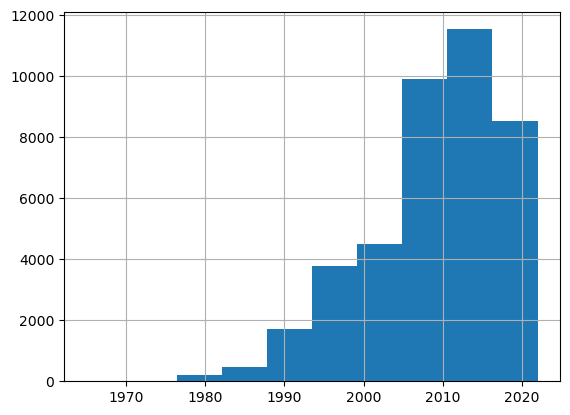

In [ ]:
# Note, that most articles have more measuremetns in them
df_dois['year'].hist()

### Initial analysis on the affect of ligands to cancer related proteins 

In [ ]:
cancer_keywords= [
    # General Cancer Terms
    "Cancer", "Tumor", "Carcinoma", "Sarcoma", "Malignancy", "Neoplasm", 
    "Metastasis", "Oncogene", "Antineoplastic", "Chemotherapy", 
    "Radiotherapy", "Immunotherapy", "Targeted therapy", "Cytotoxic", "Cancerous"
    
    # Types of Cancer - Common Solid Tumors
    "Breast cancer", "Lung cancer", "Colorectal cancer", "Pancreatic cancer", 
    "Prostate cancer", "Melanoma", "Ovarian cancer", "Brain tumor", 
    "Liver cancer", "Gastric cancer", "Esophageal cancer", "Kidney cancer",
    
    # Types of Cancer - Hematological Malignancies
    "Leukemia", "Lymphoma", "Myeloma", "Hodgkin's lymphoma", 
    "Non-Hodgkin's lymphoma", "Chronic lymphocytic leukemia (CLL)", 
    "Acute myeloid leukemia (AML)",
    
    # Molecular Targets and Mechanisms - Proteins
    "Tyrosine kinase", "EGFR", "HER2", "VEGF", "PD-1", "PD-L1", 
    "CTLA-4", "BCL-2",
    
    # Molecular Targets and Mechanisms - Genes and Pathways
    "KRAS", "TP53", "BRCA1", "BRCA2", "MYC", "PI3K", "RAS/RAF/MEK/ERK pathway", 
    "JAK/STAT pathway", "Wnt signaling", "Hedgehog pathway",
    
    # Molecular Targets and Mechanisms - Drug Mechanisms
    "Apoptosis inducer", "Angiogenesis inhibitor", "DNA alkylation", 
    "DNA intercalation", "Topoisomerase inhibitor", "Microtubule stabilizer", 
    "Immune checkpoint inhibitor",
    
    # Specific Drug Classes
    "Alkylating agents", "Antimetabolites", "Anthracyclines", "Taxanes", 
    "Platinum compounds", "Monoclonal antibodies", "PARP inhibitors", 
    "CDK inhibitors", "HDAC inhibitors", "Proteasome inhibitors", 
    "mTOR inhibitors",
    
    # Treatment-Related Terms
    "Cytotoxicity", "Resistance", "Hormone therapy", "Anti-angiogenic", 
    "Cell cycle arrest", "Radiosensitizer", "Synergistic therapy",
    
    # Emerging Terms
    "Precision oncology", "Epigenetic modulation", 
    "Adoptive cell therapy", "CAR-T cell therapy", "Tumor microenvironment", 
    "Cancer stem cells"
]

**We will rely on other columns (like Target Name) and further metadata to get the cancers and mutants more accurately**

In [ ]:
import re

# Create a single regex pattern from the list of terms (case-insensitive)
pattern = '|'.join(rf"\b{re.escape(term)}\b" for term in cancer_keywords)

# Filter rows where "specific-description" contains any of the cancer terms
filtered_df = merged_df[merged_df['specific-function'].str.contains(pattern, case=False, na=False)]

In [ ]:

mutant_keywords = [
    "mutation",
    "oncogenesis", "tumorigenesis", "apoptosis", "angiogenesis", "HER2", "BRAF", "KRAS", "EGFR",
    "BRCA1", "BRCA2", "P53", "MDM2", "CDK4", "CDK6", "V600", "G12"
]


In [ ]:
pattern_mutant = '|'.join(rf"\b{re.escape(term)}\b" for term in mutant_keywords)

# Filter rows where "specific-description" contains any of the mutant terms
mutant_df = filtered_df[filtered_df['specific-function'].str.contains(pattern_mutant, case=False, na=False)]

In [ ]:
print(f"We have {len(filtered_df)} cancer related proteins and out of them possibly {len(mutant_df)} are mutant related")

We have 26774 cancer related proteins and out of them possibly 17816 are mutant related


In [ ]:
affinity_cols = ["ki", "kd"] ## Measures of binding affinity
ec_ic = ["ic50"] #### Measures of inhibitory (IC50) and effective concentrations (EC50)
bind_unbind = ["kon"] ## Rates of binding / unbinding of ligands

binding_ligand_efficency_cols = affinity_cols + ec_ic + bind_unbind

#### Visualizing basic numerical data about the ligand-protein binding efficency and the environment in which they were tested

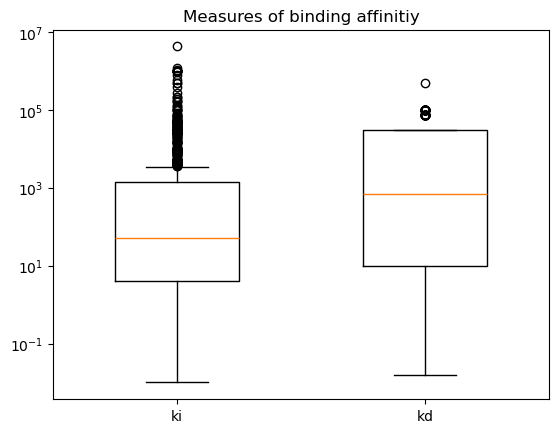

In [ ]:
for i in range(len(affinity_cols)):
    plt.boxplot(filtered_df[affinity_cols[i]].dropna(), positions = [i], widths=0.5)
plt.title("Measures of binding affinitiy")
plt.xticks(range(len(affinity_cols)), affinity_cols)
plt.yscale('log')
plt.show()

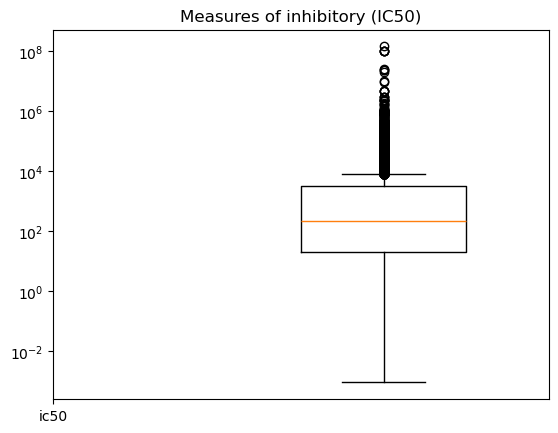

In [ ]:
plt.boxplot(filtered_df["ic50"].dropna(), positions = [i], widths=0.5)
plt.title("Measures of inhibitory (IC50)")
plt.xticks(range(len(ec_ic)), ec_ic)
#plt.ylim([-0.3, 1000])
plt.yscale('log')
plt.show()

Text(0.5, 1.0, 'Histogram of NaN percentages for columns')

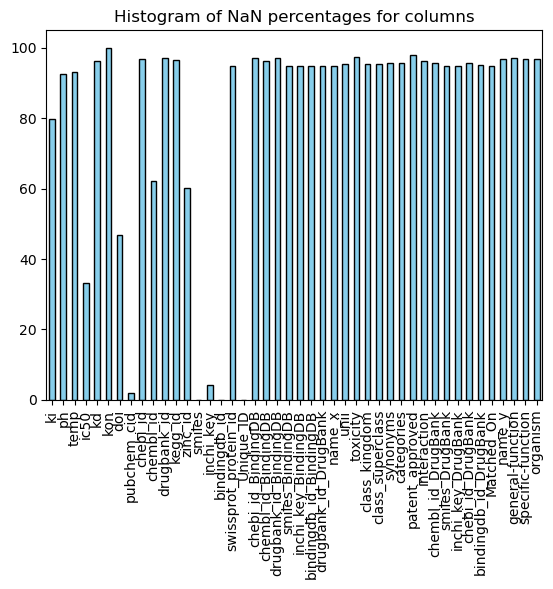

In [ ]:
nan_counts_per_col = merged_df.isna().mean(axis=0)*100
nan_counts_per_col.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Histogram of NaN percentages for columns")

Text(0.5, 0, 'ph')

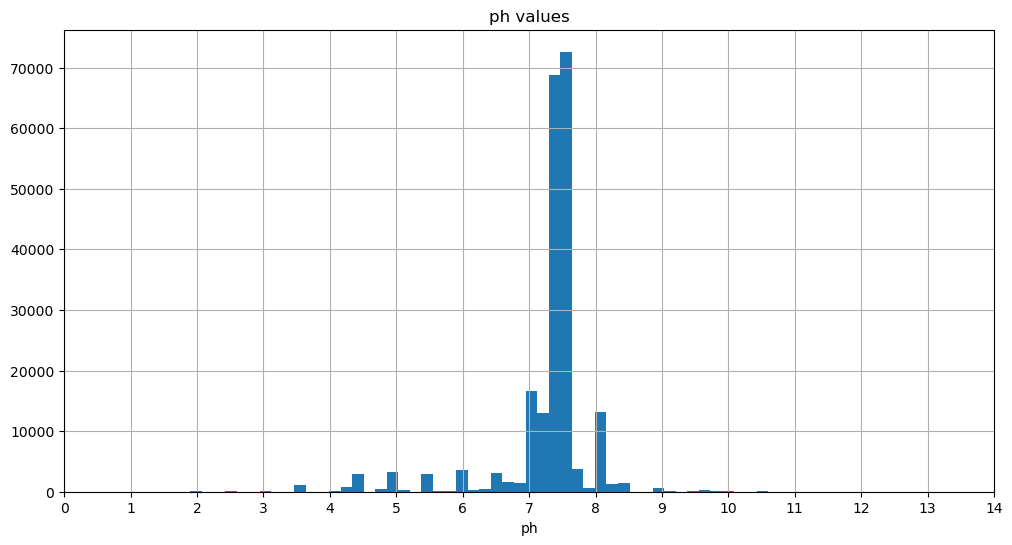

In [ ]:
plt.figure(figsize=(12, 6)) 
merged_df['ph'].hist(bins = 50)
plt.xticks(np.arange(15))
plt.title("ph values")
plt.xlabel("ph")


Text(0.5, 0, 'Celsius degrees')

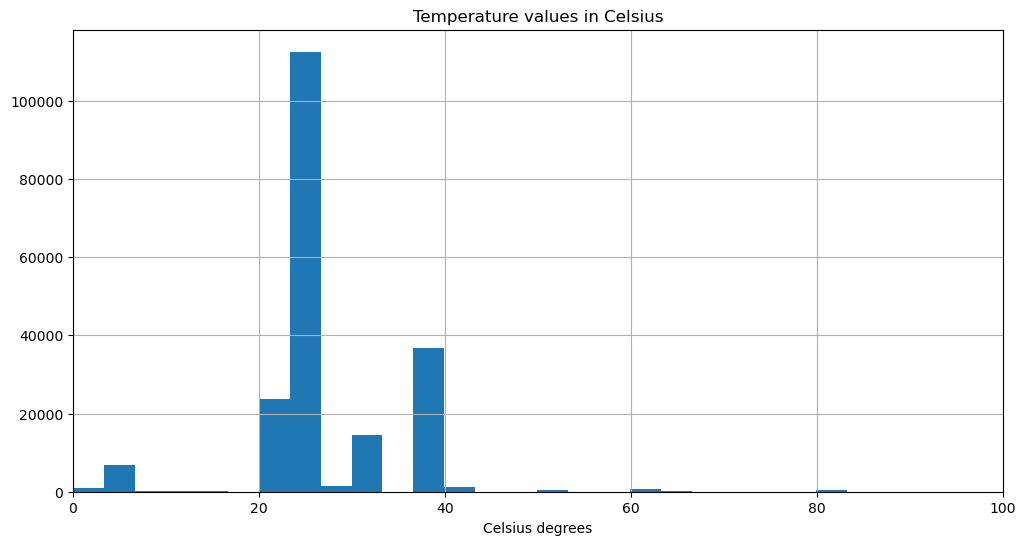

In [ ]:
plt.figure(figsize=(12, 6)) 
merged_df['temp'].hist(bins = 500)
plt.title("Temperature values in Celsius")
plt.xlim([0, 100])
plt.xlabel("Celsius degrees")

### Mutations
- Correlation between metrics of biding affinity, dosage, etc
- Possibly trying to see some groupings of data points (similarity in structure, metrics, types of disease being fought, ...)

In [ ]:
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats import diagnostic
from scipy import stats


ModuleNotFoundError: No module named 'networkx'

In [ ]:
merged_df_2 = merged_df[["ki", "ic50", "kd", "ph", "temp"]].dropna()

In [ ]:
merged_df_2

,ki,ic50,kd,ph,temp
32414,50.0,2000.0,270.0,7.5,25.0
403630,5500.0,19600.0,496.0,7.3,25.0
403631,91100.0,335000.0,954.0,7.3,25.0
403633,2800.0,9900.0,256.0,7.3,25.0
403635,2000.0,7200.0,264.0,7.3,25.0
403637,9600.0,34100.0,380.0,7.3,25.0
403638,96600.0,341000.0,496.0,7.4,25.0
403639,14900.0,52700.0,291.0,7.4,25.0
403640,355500.0,1258500.0,264.0,7.4,25.0


In [ ]:
print(diagnostic.kstest_normal(merged_df_2["ki"].values, dist = 'norm'))
print(diagnostic.kstest_normal(merged_df_2["ki"].values, dist = 'exp'))
print(diagnostic.kstest_normal(merged_df_2["ic50"].values, dist = 'norm'))
print(diagnostic.kstest_normal(merged_df_2["ic50"].values, dist = 'exp'))
print(diagnostic.kstest_normal(merged_df_2["kd"].values, dist = 'norm'))
print(diagnostic.kstest_normal(merged_df_2["kd"].values, dist = 'exp'))

(0.3316297918004256, 0.005464736952897225)
(0.45962321542124196, 0.0015567131690047327)
(0.3329414971146777, 0.005055785987452595)
(0.4610074446102134, 0.0014676254914479862)
(0.25237112659389244, 0.09962614601795748)
(0.4661401359792068, 0.001137290343683231)
